In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import matplotlib.pyplot as plt

In [4]:
export_base = '191009_ratti_cancer_genes_decades'

In [5]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import spearmanr
import matplotlib.pyplot as plt

from access_biology_data import meta, gwas_studies, relations
from access_literature_data import medline, wos
from access_science_shared import standardizer

src_dir = '/Users/tstoeger/Projects/recit/src/'
sys.path[0] = src_dir

import studies
import fullfill
import recit_tools as ret

import nar190730

from scipy.stats import wilcoxon

In [6]:
save_images = False
taxon_id = 9606

In [7]:
all_gene_info = meta.gene_info(9606, ['gene_ncbi', 'symbol_ncbi', 'type_of_gene'])
all_gene_info = all_gene_info.drop_duplicates('symbol_ncbi', keep=False)   # NCG uses symbols that can ambiguous
all_gene_info = all_gene_info[all_gene_info['type_of_gene']=='protein-coding'].drop('type_of_gene', 1)

In [8]:
from access_literature_data import medline

In [9]:
g2p = medline.gene2pubmed(taxon_id='all', paper_kind='research').drop_duplicates()

In [10]:
g2p = pd.merge(
    g2p, 
    (1 / g2p['pubmed_id'].value_counts()).to_frame('attention').rename_axis('pubmed_id').reset_index())

In [11]:
g2p.loc[:, 'papers'] = 1

In [12]:
years = medline.select_medline_records(
        columns_sql='''
            medline.pubmed_id,
            medline.pubdate_year''',
        taxon_id=None,
        kind='research')

In [13]:
literature = pd.merge(g2p, years)
literature = literature[literature['pubdate_year'].isin(range(1980, 2016))]
literature = literature[literature['taxon_ncbi']==taxon_id]
literature = literature.drop('taxon_ncbi', 1)

In [14]:
# literature = literature[literature['gene_ncbi'].isin(all_gene_info['gene_ncbi'])]

In [15]:
total_annual_literature = literature[
    ['pubdate_year', 'attention']].groupby('pubdate_year').agg(sum).rename(
    columns={'attention': 'annual_attention'}
).reset_index()

In [16]:


fame_per_gene_per_year = literature[
    ['gene_ncbi', 'pubdate_year', 'attention', 'papers']
].groupby(['gene_ncbi', 'pubdate_year']).agg(sum).reset_index()

fame_per_gene_per_year = pd.merge(
    fame_per_gene_per_year,
    total_annual_literature
)

fame_per_gene_per_year.loc[:, 'attention_share'] = fame_per_gene_per_year[
    'attention'] / fame_per_gene_per_year['annual_attention']

In [17]:
p = '/Users/tstoeger/Dropbox/ratti/data/network_of_cancer_genes/ncg6_0/cancergenes_list.txt'
df_ncg = pd.read_csv(p, '\t')

In [18]:
cancer_genes = all_gene_info[all_gene_info['symbol_ncbi'].isin(df_ncg['711_Known_Cancer_Genes'])]

In [19]:
mega = pd.merge(
    cancer_genes,
    fame_per_gene_per_year[['pubdate_year', 'gene_ncbi', 'attention', 'attention_share', 'papers']]
)

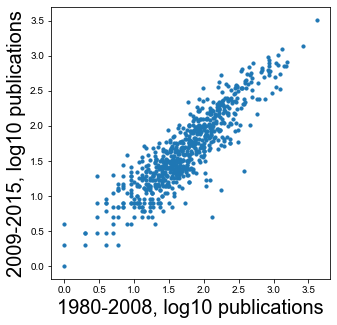

In [20]:
m = mega.copy()
m.loc[:, 'before'] = m['pubdate_year'] < 2009
m = m[['before', 'papers', 'symbol_ncbi']
        ].groupby(['before', 'symbol_ncbi']).agg(
    sum).reset_index()

h = m.pivot(index='symbol_ncbi', columns='before', values='papers')
h.columns = [str(int(x)) for x in h.columns]
h = h.rename(columns={'0': 'until 2008', '1': '2009-2015'})

plt.figure(figsize=(5, 5))

plt.scatter(
    np.log10(h.loc[:, 'until 2008']), 
    np.log10(h.loc[:, '2009-2015']), s=10)

plt.xlabel('1980-2008, log10 publications', fontsize=20)
plt.ylabel('2009-2015, log10 publications', fontsize=20)

if save_images:
    ret.export_image('{}/attention_scatter.pdf'.format(export_base))

In [21]:
h.corr('spearman')

,until 2008,2009-2015
until 2008,1.000000,0.876801
2009-2015,0.876801,1.000000


In [22]:
if save_images:
    ret.export_full_frame('{}/inspect_paper_format.xlsx'.format(export_base), h, save_index=False)

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log2
  


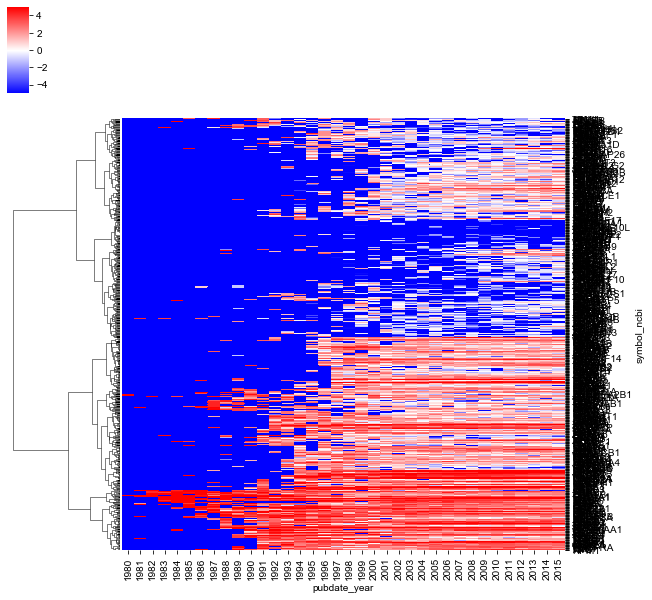

In [23]:
m = mega.copy()

m = m[['gene_ncbi', 'symbol_ncbi', 'pubdate_year', 'attention_share']]

g = m.pivot(index='symbol_ncbi', columns='pubdate_year', values='attention_share')

y= [x for x in range(1980, 2016)]
g = g.loc[:, y].fillna(0)





u = np.log2(g[y]/(1/all_gene_info.shape[0]))

u[u<-5] = -10

u[u>10] = 10

sns.clustermap(
    u, 
    col_cluster=False,
    cmap='bwr',
    method='ward',
    vmin=-5,
    vmax=5,
    yticklabels=True
)

In [24]:
m

,gene_ncbi,symbol_ncbi,pubdate_year,attention_share
0,25,ABL1,1986,2.117674e-03
1,25,ABL1,1987,9.529834e-04
2,25,ABL1,1989,1.155124e-03
3,25,ABL1,1996,7.047984e-04
4,25,ABL1,2002,6.037386e-04
5,25,ABL1,2004,3.395215e-04
6,25,ABL1,2005,4.565602e-04
7,25,ABL1,2006,3.934002e-04
8,25,ABL1,2008,5.649976e-04
9,25,ABL1,2009,5.541183e-04


/Users/tstoeger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log2


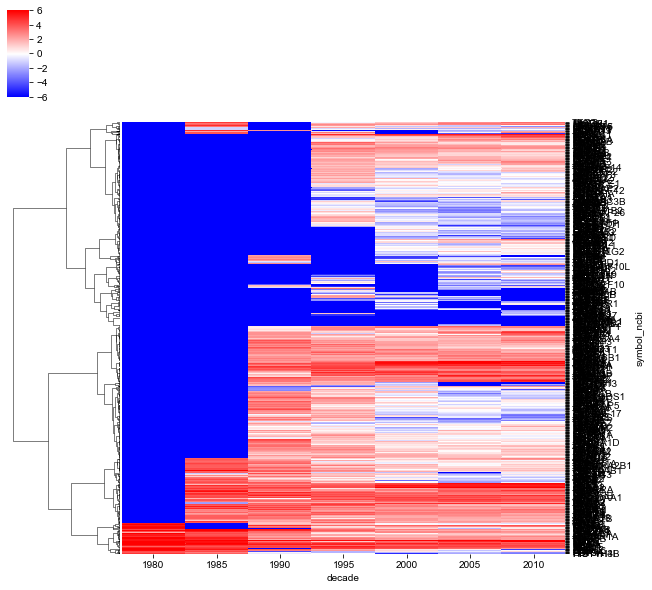

In [25]:
m = mega.copy()

y = [1980, 1985, 1990, 1995, 2000, 2005, 2010]

for yy in y:
    f = m['pubdate_year'].isin(range(yy, yy+5))
    m.loc[f, 'decade'] = yy

# m['decade'] = m['pubdate_year'].apply(lambda x: np.floor(x/10)*10)

m = m[['gene_ncbi', 'symbol_ncbi', 'decade', 'attention_share']].groupby(
    ['gene_ncbi', 'symbol_ncbi', 'decade']
).agg(np.median).reset_index()

g = m.pivot(index='symbol_ncbi', columns='decade', values='attention_share')




g = g.loc[:, y].fillna(0)


all_gene_info.shape

u = np.log2(g[y]/(1/all_gene_info.shape[0]))

u[u<-5] = -10

u[u>10] = 10

sns.clustermap(
    u, 
    col_cluster=False,
    cmap='bwr',
    method='ward',
    vmin=-6,
    vmax=6,
    yticklabels=True
)

In [26]:
gm = g.copy()

In [27]:
gm.loc[:, 'highest'] = 0

In [28]:
for c in y:
    f = gm[c] >= gm['highest']
    gm.loc[f, 'decade'] = c
    gm.loc[f, 'highest'] = gm.loc[f, c]

In [29]:
gm['decade'].value_counts()

1995.0    184
2010.0    136
1990.0    131
1985.0     78
2000.0     74
2005.0     63
1980.0     39
Name: decade, dtype: int64

In [30]:
co = gm['decade'].value_counts() 

co/ co.sum()

1995.0    0.260993
2010.0    0.192908
1990.0    0.185816
1985.0    0.110638
2000.0    0.104965
2005.0    0.089362
1980.0    0.055319
Name: decade, dtype: float64

In [31]:
(co[1980] + co[1985] + co[1990] + co[1995]) / co.sum()

0.6127659574468085

In [32]:
0.260993 

0.260993

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


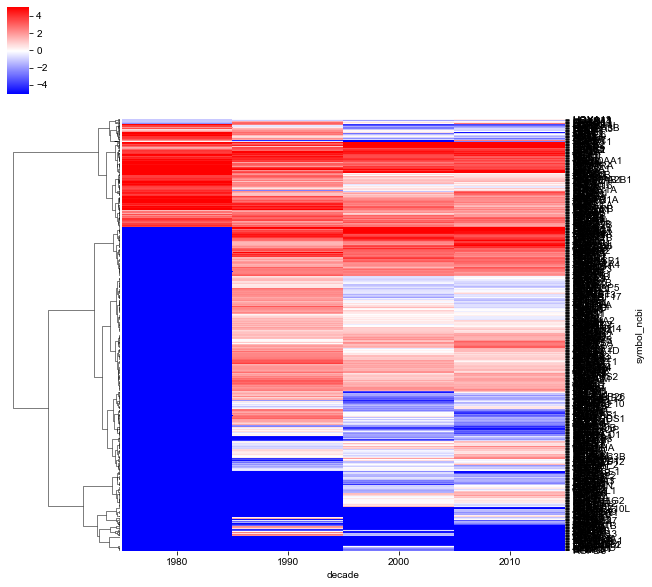

In [33]:
m = mega.copy()

m['decade'] = m['pubdate_year'].apply(lambda x: np.floor(x/10)*10)

m = m[['gene_ncbi', 'symbol_ncbi', 'decade', 'attention_share']].groupby(
    ['gene_ncbi', 'symbol_ncbi', 'decade']
).agg(np.median).reset_index()

g = m.pivot(index='symbol_ncbi', columns='decade', values='attention_share')

g = g.loc[:, [1980, 1990, 2000, 2010]].fillna(0)


all_gene_info.shape

u = np.log2(g[[1980, 1990, 2000, 2010]]/(1/all_gene_info.shape[0]))

u[u<-5] = -10

u[u>10] = 10

sns.clustermap(
    u, 
    col_cluster=False,
    cmap='bwr',
    method='ward',
    vmin=-5,
    vmax=5,
    yticklabels=True
)

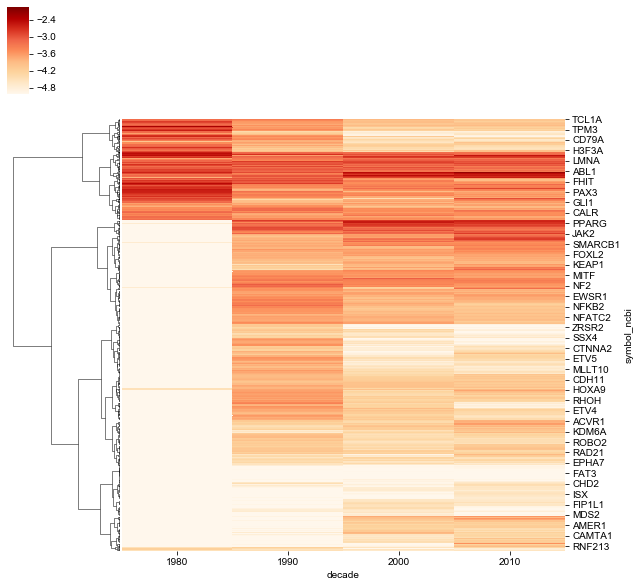

In [34]:
sns.clustermap(
    g[[1980, 1990, 2000, 2010]].apply(lambda x: np.log10(x+0.00001)), 
    col_cluster=False,
    cmap='OrRd',
    method='ward')



ValueError: could not convert string to float: 'ABL1'

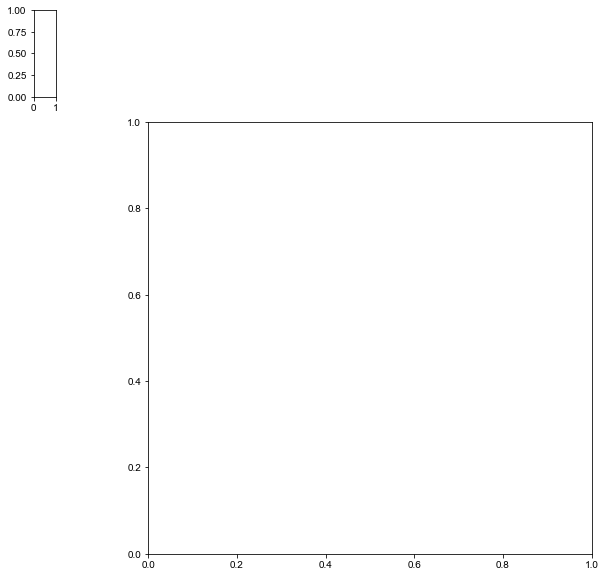

In [35]:
sns.clustermap(
    m, 
    col_cluster=False, 
    vmin=0, 
    vmax=1, 
    cmap='OrRd',
    method='ward')


if save_images:
    ret.export_image('{}/attention_clustermap_max_fraction_of_annual.pdf'.format(export_base))

In [ ]:
sns.clustermap(
    z, 
    col_cluster=False, 
    vmin=-3, 
    vmax=3, 
    cmap='bwr',
    method='ward')

if save_images:
    ret.export_image(
        '{}/attention_clustermap_zscored_fraction_of_annual.pdf'.format(export_base))